<a href="https://colab.research.google.com/github/Dushyanttara/colab_research/blob/master/RF%20%26%20Adboost%20from%20scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Ensemble Methods

Previously in the coding section we created a Decision Tree from scratch and in the theoretical sections we have been discussing about Ensemble methods since then. 
So today we will try to create Random Forest & AdaBoost algorithm from scratch.



### Decision Tree & Utilities functions

In [0]:
import numpy as np

In [0]:
import numpy as np
from collections import Counter
def entropy(y):
  hist = np.bincount(y)
  ps = hist /len(y)
  return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:
  def __init__(self, feature = None, threshold = None, left =None, right=None, *, value=None):
    self.feature = feature
    self.threshold=threshold
    self.left=left
    self.right = right
    self.value = value

  def is_leaf_node(self):
    return self.value is not None


class DecisionTree:
  
  def __init__(self, min_samples_split =2, max_depth=100, n_feats=None):
    self.min_samples_split = min_samples_split
    self.max_depth = max_depth
    self.n_feats= n_feats
    self.root = None

  def fit(self, X, y):
    # grow the tree
    self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
    self.root = self._grow_tree(X, y)
  
  def _grow_tree(self, X, y, depth = 0):
    n_samples, n_features = X.shape
    n_labels = len(np.unique(y))

    #stopping criteria
    if (depth >=self.max_depth
        or n_labels == 1
        or n_samples < self.min_samples_split):
      leaf_value = self._most_common_label(y)
      return Node(value=leaf_value)

    feat_idxs = np.random.choice(n_features, self.n_feats, replace = False)

    #greedy search
    best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
    left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
    left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
    right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
    return Node(best_feat, best_thresh,left, right)


  def _best_criteria(self,X, y, feat_idxs):
    best_gain = -1
    split_idx, split_thresh = None, None
    for feat_idx in feat_idxs:
      X_column = X[:,feat_idx]
      thresholds = np.unique(X_column)
      for threshold in thresholds:
        gain = self._information_gain(y, X_column, threshold)

        if gain > best_gain:
          best_gain = gain
          split_idx = feat_idx
          split_thresh = threshold

    return split_idx, split_thresh

  def _information_gain(self, y, X_column, split_thresh):
    # parent E
    parent_entropy = entropy(y)
    #generate split
    left_idxs, right_idxs = self._split(X_column, split_thresh)
    
    if len(left_idxs)== 0 or len(right_idxs ==0):
      return 0
    #weghted avg child E
    n = len(y)
    n_l, n_r = len(left_idxs), len(right_idxs)
    e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
    child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
    #return ig
    ig = parent_entropy - child_entropy
    return ig

  def _split(self, X_column,split_thresh ):
    left_idxs = np.argwhere(X_column <= split_thresh).flatten()
    right_idxs = np.argwhere(X_column > split_thresh).flatten()
    return left_idxs, right_idxs


  def predict(self, X):
    #traverse tree
    return np.array([self._traverse_tree(x, self.root) for x in X])

  def _traverse_tree(self, x, node):
    if node.is_leaf_node():
      return node.value

    if x[node.feature] <= node.threshold:
      return self._traverse_tree(x,node.left)
    return self._traverse_tree(x, node.right)

  

  def _most_common_label(self, y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [20]:
#Decision Tree tests

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

#from decision_tree import DecisionTree


def accuracy(y_true, y_pred):
  accuracy = np.sum(y_true == y_pred)/ len(y_true)
  return accuracy


data = datasets.load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train ,y_test = train_test_split(X, y, test_size = 0.2, random_state=1234)


clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

print("Accuracy", acc)

Accuracy 0.5964912280701754


In [6]:
y= [1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0]
counter = Counter(y)
most_common = counter.most_common()
most_common

[(0, 11), (1, 7)]

### Random Forest

Let's start first with Random Forest Algorithm.
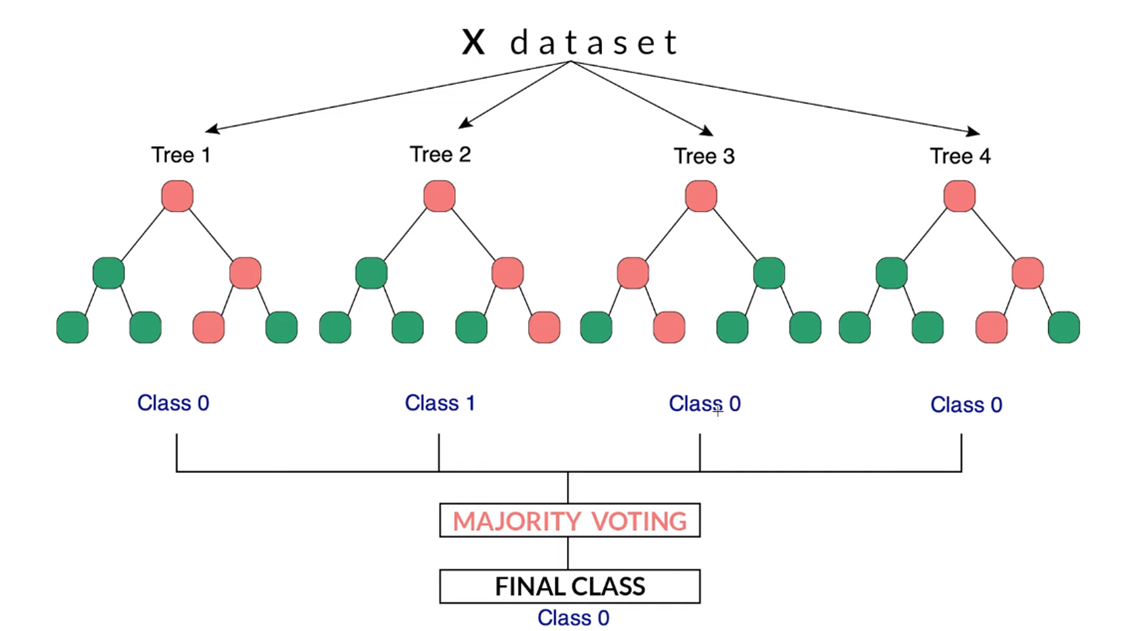

In [0]:
import numpy as np
#from decision_tree import DecisionTree
from collections import Counter

def bootstrap_sample(X, y):
  n_samples = X.shape[0]
  idxs = np.random.choice(n_samples, size = n_samples, replace =True)
  return X[idxs], y[idxs]

def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common


class RandomForest:

  def __init__(self,n_trees=100, min_samples_split =2, max_depth=100, n_feats=None):
    self.n_trees = n_trees
    self.min_samples_split = min_samples_split
    self.max_depth = max_depth
    self.n_feats = n_feats
    self.trees = []

  def fit(self, X, y):
    self.trees = []
    for _ in range(self.n_trees):
      tree = DecisionTree(min_samples_split=self.min_samples_split, max_depth=self.max_depth, n_feats=self.n_feats)
      X_sample, y_sample  = bootstrap_sample(X, y)
      tree.fit(X_sample, y_sample)
      self.trees.append(tree)


  def predict(self, X):
    tree_preds = np.array([tree.predict(X) for tree in self.trees])
    #[1111 0000 1111]  
    #[101 101 101 101]
    tree_preds = np.swapaxes(tree_preds, 0,1)
    #101 101 101
    y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
    return np.array(y_pred)


In [25]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

#from random_forest import RandomForest

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

data = datasets.load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

clf = RandomForest(n_trees=3, max_depth=10)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

print ("Accuracy:", acc)

Accuracy: 0.6052631578947368


### AdaBoost

AdaBoost uses boosting to improve performance
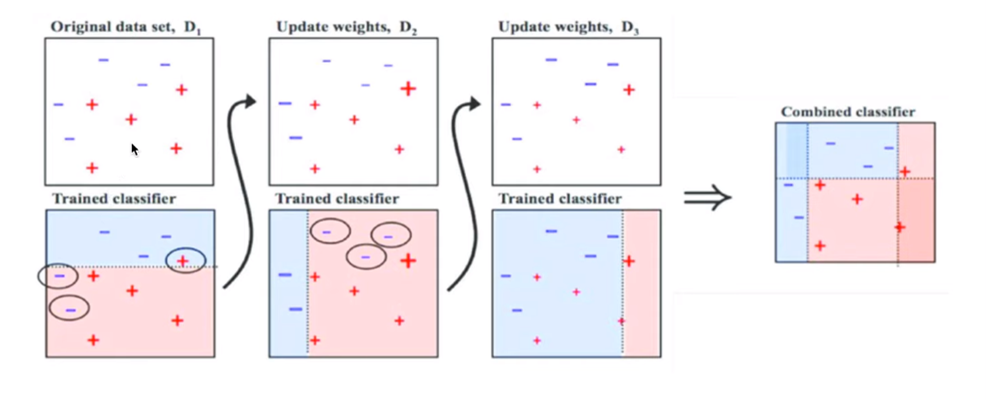

Weak Learner(Decision Stump)
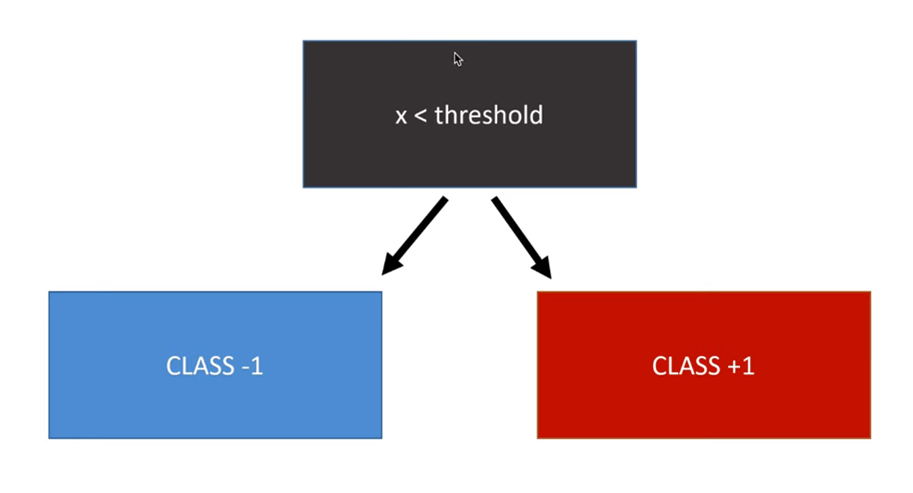

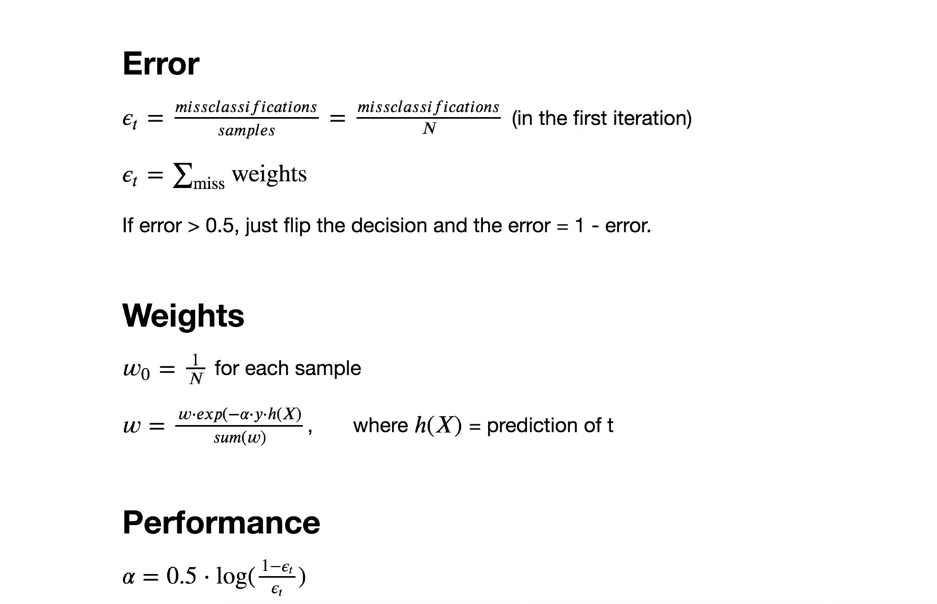

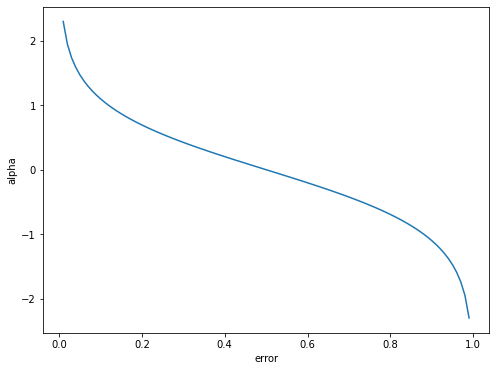

In [26]:
import numpy as np
import matplotlib.pyplot as plt
alpha = lambda x: 0.5 * np.log((1.0 -x) / x)
error = np.arange(0.01, 1.00, 0.01)

plt.figure(figsize = (8,6))
plt.xlabel('error')
plt.ylabel('alpha')
plt.plot(error, alpha(error))
plt.show()

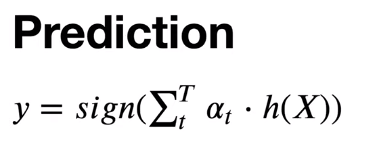

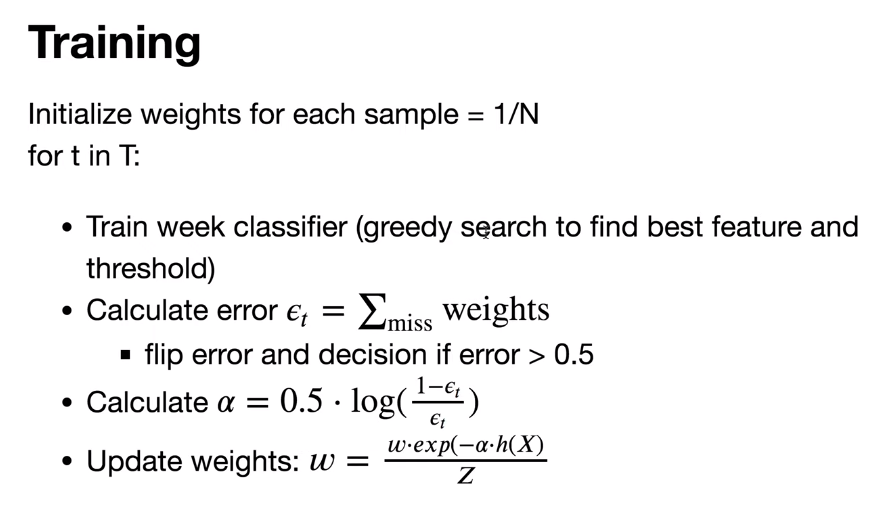

In [0]:
import numpy as np

# Decision stump used as weak classifier
class DecisionStump():
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions


class Adaboost():

    def __init__(self, n_clf=5):
        self.n_clf = n_clf

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = DecisionStump()

            min_error = float('inf')
            # greedy search to find best threshold and feature
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # predict with polarity 1
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    # Error = sum of weights of misclassified samples
                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # store the best configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # calculate alpha
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # calculate predictions and update weights
            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred

Testing Adaboost algorithm

In [34]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

#from adaboost import Adaboost

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

data = datasets.load_breast_cancer()
X = data.data
y = data.target

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Adaboost classification with 5 weak classifiers
clf = Adaboost(n_clf=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy(y_test, y_pred)
print ("Accuracy:", acc)

Accuracy: 0.9736842105263158
